# Moving around regular graphs with flags

This notebook lets us explore a means of navigating planar graphs (with a certain kind of symmetry) by applying "nullary" operations in a particular order.

That is, the user is presented with a graph and a "starting point", and by providing strings of operations (`v`, `e`, and `f`), their starting point will move around the graph.

The last cell has the demo, so if you "Restart and run all" you can play with it down at the bottom.

**Implementation Note**

The vast majority of the implementation here is about drawing points moving on a very simple graph, and the approach is a little nonstandard.  So here's a brief description of the approach:

We have a hardcoded graph diagram, and to show flags moving on that graph, we simply change the colors of the graph facets to indicate "active" or "inactive" facets.

The diagrams being output are SVGs, which are XML.  XML is obnoxious to work with using native libraries like lxml, so we use xmltodict and the lenses package to treat the SVG XML like a big dictionary.

xmltodict will take an XML file and turn it into a list of dictionaries whose keys are tag names.  The values for each tag name are themselves lists of dictionaries, and nesting continues recursively.  Tag *attributes* are modeled as keys prefixed with "@".  So the id attribute of a top-level "p" tag might be at `root['p'][0]['@id']`, for example.

The lenses library allows you to create [lenses](https://python-lenses.readthedocs.io/en/latest/tutorial/intro.html), which are essentially views into nested data structures.  You create a lens object that "focuses" on part of a data structure, and that object will have ways to get the data that you're focusing on out of a structure.

They're different from, say, "getter functions" in that you can use them to also *set* the data you're focusing on within the structure.  Furthermore, your "view" doesn't have to simply be a slice of the structure you're traversing.  For example, here we have a lens which focuses on an XML string *as a dictionary*, and we can use lens setters to modify the dictionary.  The lens will then *change the XML string* in the appropriate way.

In [1]:
from lenses import lens
import xmltodict

# Set up the lens which will let us "focus" on XML markup as a dictionary
xml_dict_iso = lens.Iso(xmltodict.parse, xmltodict.unparse)

In [2]:
# Create functions which return lenses onto the vertex, edge, and face elements in our SVG.
#
# The vertex, edge, and face elements are ellipses, paths, and again ellipses whose names
# are e.g. vertex1, edge1_2, face1_2_4, etc.
#

def lens_vertex(i):
    return lens['svg']['g']['ellipse'].Each().Filter(lambda el: el['@id'] == 'vertex{}'.format(i))

def lens_edge(i, j):
    return lens['svg']['g']['path'].Each().Filter(lambda el: el['@id'] == 'edge{}_{}'.format(i, j))

def lens_face(*vertices):
    return lens['svg']['g']['ellipse'].Each().Filter(lambda el: el['@id'] == 'face' + '_'.join(map(str, vertices)))

In [3]:
def dict_from_style_kv(s):
    return dict((k, v) for (k, v) in [ss.split(':', 1) for ss in s.split(';')])

def style_kv_from_dict(d):
    return ';'.join('{}:{}'.format(k, v) for (k, v) in d.items())

# Set up the lens which will let us "focus" on a big CSS-like "style string" as a dictionary
dict_kv_iso = lens.Iso(dict_from_style_kv, style_kv_from_dict)

In [4]:
# Set up the conventions for coloring active and inactive facets of the graph

# Set some color constants
active_color = '#dd2a2b'
vertex_inactive_color = '#ffffff'
edge_inactive_color = '#000000'
face_inactive_color = '#ffffff'

# Set up the lenses which focus on the appropriate color property for each type of facet
vertex_style = lens['@style'] & dict_kv_iso & lens['fill']
edge_style = lens['@style'] & dict_kv_iso & lens['stroke']
face_style = lens['@style'] & dict_kv_iso & lens['fill']

In [5]:
from cytoolz import get, merge, partial, keyfilter, valfilter
from itertools import count
import re
from IPython.display import SVG, display

def named_pair(field='@id'):
    return lens.Lens(
        lambda pair: merge(pair[1], {field: pair[0]}),
        lambda pair, update: (update[field], keyfilter(lambda k: k != field, update)),
    )

def subdict(keys, dic):
    return dict(zip(keys, get(list(keys), dic, default=None)))

def update_with_subdict(dic, update):
    return merge(dic, valfilter(lambda v: v is not None, update))

def subdict_lens(*items):
    return lens.Lens(partial(subdict, items), update_with_subdict)

vertices = (
    xml_dict_iso &
    lens['svg']['g']['ellipse'].Each() &
    lens.Filter(
        lambda ell: (lens['@style'] & dict_kv_iso & lens['stroke']).get()(ell) == '#000000'
    )
)
vertex_styles = (
    vertices &
    lens.Tuple(
        lens['@id'],
        lens['@style'] & dict_kv_iso,
    )
)

edges = (
    xml_dict_iso &
    lens['svg']['g']['path'].Each() &
    lens.Tuple(
        lens['@id'],
        lens['@inkscape:connection-start'],
        lens['@inkscape:connection-end'],
    )
)

faces = (
    xml_dict_iso &
    lens['svg']['g']['ellipse'].Each() &
    lens.Tuple(
        lens['@id'],
        lens['@style'] & dict_kv_iso,
    ) &
    lens.Filter(lambda pair: pair[1]['stroke'] != '#000000')
)

labels = (
    xml_dict_iso &
    lens['svg']['g']['text'].Each()
)

numeric = lens.Iso(lambda s: float(s), lambda f: str(f))
vertex_positions = (
    vertices &
    lens.Tuple(lens['@id'], lens['@cx'] & numeric, lens['@cy'] & numeric)
)
label_positions = (
    labels &
    lens.Tuple(lens['@id'], lens['@x'] & numeric, lens['@y'] & numeric, lens['tspan']['#text'])
)

def label_edge(edge):
    (eid, v1, v2) = edge
    v1_num = int(v1.replace('#vertex', ''))
    v2_num = int(v2.replace('#vertex', ''))
    v = sorted([v1_num, v2_num])
    return ('edge{}_{}'.format(*v), v1, v2)

def label_vertices(vertices, labels):
    result = {}
    for (vertex, x, y) in vertices:
        result[vertex] = min(((lx - x)**2 + (ly - y)**2, lt) for (lt, lx, ly, _) in labels)[1]
    return {label: int(vertex.replace('vertex', '')) for (vertex, label) in result.items()}

"""
with open('dodecahedron.svg') as f:
    xml = f.read()

vertex_ids = ('vertex{}'.format(i) for i in count(1))
vertex_renames = zip(vertex_styles[0].collect()(xml), vertex_ids)
for (text, replacement) in vertex_renames:
    xml = re.sub(r'\b{}\b'.format(text), replacement, xml)
    
xml = edges.modify(label_edge)(xml)

labeling = label_vertices(vertex_positions.collect()(xml), label_positions.collect()(xml))

xml = label_positions.modify(lambda lxyt: (lxyt[0], lxyt[1], lxyt[2], str(labeling[lxyt[0]])))(xml)

with open('dodecahedron_edit.svg', 'w') as f:
    f.write(xml)

display(SVG(xml))

face_names = (
    xml_dict_iso &
    lens['svg']['g']['ellipse'].Each() &
    lens.Filter(lambda ell: 'face' in ell['@id'])['@id']
).collect()(xml)
[tuple(map(int, f.replace('face', '').split('_'))) for f in face_names]
"""

"\nwith open('dodecahedron.svg') as f:\n    xml = f.read()\n\nvertex_ids = ('vertex{}'.format(i) for i in count(1))\nvertex_renames = zip(vertex_styles[0].collect()(xml), vertex_ids)\nfor (text, replacement) in vertex_renames:\n    xml = re.sub(r'\x08{}\x08'.format(text), replacement, xml)\n    \nxml = edges.modify(label_edge)(xml)\n\nlabeling = label_vertices(vertex_positions.collect()(xml), label_positions.collect()(xml))\n\nxml = label_positions.modify(lambda lxyt: (lxyt[0], lxyt[1], lxyt[2], str(labeling[lxyt[0]])))(xml)\n\nwith open('dodecahedron_edit.svg', 'w') as f:\n    f.write(xml)\n\ndisplay(SVG(xml))\n\nface_names = (\n    xml_dict_iso &\n    lens['svg']['g']['ellipse'].Each() &\n    lens.Filter(lambda ell: 'face' in ell['@id'])['@id']\n).collect()(xml)\n[tuple(map(int, f.replace('face', '').split('_'))) for f in face_names]\n"

In [6]:
from contextlib import contextmanager
from IPython.display import SVG, display


def _ms(*lst):
    """
    Normalize edge and face names.
    
    Edges and faces have names with indices in increasing order,
    so for example if we compute that we want to mess with edge (4, 3),
    this function will normalize this to (3, 4).
    """
    return tuple(sorted(lst))


def require_started(func):
    """
    Method decorator which makes sure a flag is started.
    
    If we are missing an active vertex, edge, or face, we can't use
    some of the methods in ``SVGArtist``.  This marks those methods
    so they can all fail consistently.
    """
    def _wrapped(self, *args, **kwargs):
        if None in [self.vertex, self.edge, self.face]:
            raise ValueError('No flag has been started in "{}"'.format(self))
        return func(self, *args, **kwargs)
    return _wrapped


@contextmanager
def showing(artist):
    """Context manager which displays the SVGArtist upon exit."""
    try:
        yield
    finally:
        artist.show()


class SVGArtist(object):
    """
    Represent an SVG graph.
    
    Knows how to draw flags moving around on the graph, and also
    knows about how the primitive mirrors swap facets.
    """

    def __init__(self, svg_file, faces):
        self.path = svg_file
        self.faces = faces
        self.svg = ""
        self.vertex = None
        self.edge = None
        self.face = None
        self.reload()

    def reload(self):
        with open(self.path, 'r') as f:
            self.svg = f.read()
  
    def activate_vertex(self, i):
        self.vertex = i
        self.svg = (xml_dict_iso & lens_vertex(i) & vertex_style).set(active_color)(self.svg)
        
    def deactivate_vertex(self, i):
        self.vertex = None
        self.svg = (xml_dict_iso & lens_vertex(i) & vertex_style).set(vertex_inactive_color)(self.svg)

    def activate_edge(self, i, j):
        self.edge = (i, j)
        self.svg = (xml_dict_iso & lens_edge(i, j) & edge_style).set(active_color)(self.svg)

    def deactivate_edge(self, i, j):
        self.edge = None
        self.svg = (xml_dict_iso & lens_edge(i, j) & edge_style).set(edge_inactive_color)(self.svg)

    def activate_face(self, *vertices):
        self.face = vertices
        self.svg = (xml_dict_iso & lens_face(*vertices) & face_style).set(active_color)(self.svg)
        
    def deactivate_face(self, *vertices):
        self.face = None
        self.svg = (xml_dict_iso & lens_face(*vertices) & face_style).set(face_inactive_color)(self.svg)
        
    def default_start(self):
        face = self.faces[0]
        self.activate_vertex(face[0])
        self.activate_edge(face[0], face[1])
        self.activate_face(*face)
    
    @require_started
    def vertex_swap(self):
        vertex = next(i for i in self.edge if i != self.vertex)
        self.deactivate_vertex(self.vertex)
        self.activate_vertex(vertex)

    @require_started
    def edge_swap(self):
        vertex_pos = self.face.index(self.vertex)
        other_vertex_right = self.face[(vertex_pos + 1) % len(self.face)]
        other_vertex_left = self.face[(vertex_pos - 1) % len(self.face)]
        inactive_vertex = next(v for v in self.edge if v != self.vertex)
        if inactive_vertex == other_vertex_right:
            edge = _ms(self.vertex, other_vertex_left)
        elif inactive_vertex == other_vertex_left:
            edge = _ms(self.vertex, other_vertex_right)
        else:
            raise ValueError('Edge {} not aligned with vertex {}'.format(self.edge, self.vertex))
        self.deactivate_edge(*self.edge)
        self.activate_edge(*edge)
    
    @require_started
    def face_swap(self):
        face = next(
            f for f in self.faces
            if (
                all(v in f for v in self.edge) and
                set(f) != set(self.face)
            )
        )
        self.deactivate_face(*self.face)
        self.activate_face(*face)
        
    def show(self):
        """Display the graph SVG in the IPython notebook."""
        display(SVG(self.svg))


# Instantiate an SVGArtist for the included tetrahedral graph SVG.
a = SVGArtist('tetrahedron.svg', faces=[(1, 2, 3), (1, 2, 4), (2, 3, 4), (1, 3, 4)])

# And here's one for the cubic graph SVG.
b = SVGArtist('cube.svg', faces=[(1, 2, 6, 5), (2, 3, 7, 6), (3, 4, 8, 7), (1, 5, 8, 4), (1, 2, 3, 4), (5, 6, 7, 8)])

# The formidable dodecahedron:
c = SVGArtist(
    'dodecahedron.svg',
    faces=[
        (1, 9, 15, 14, 10),
        (2, 8, 11, 15, 9),
        (3, 7, 12, 11, 8),
        (4, 6, 13, 12, 7),
        (5, 10, 14, 13, 6),
        (11, 12, 13, 14, 15),
        (3, 17, 18, 4, 7),
        (4, 18, 19, 5, 6),
        (1, 10, 5, 19, 20),
        (1, 9, 2, 16, 20),
        (2, 16, 17, 3, 8),
    ],
)

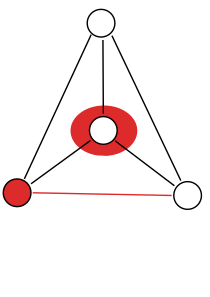

swap (v/e/f/q=quit): q


In [7]:
# Interactively allow the user to traverse the graph with mirror
# operations.

a.default_start()
a.show()

cmd_map = {
    'v': a.vertex_swap,
    'e': a.edge_swap,
    'f': a.face_swap,
}

while True:
    cmd_string = input('swap (v/e/f/q=quit): ')
    if 'q' in cmd_string.lower():
        break
    cmds = [
        cmd_map.get(s, lambda: print('unknown command; doing nothing'))
        for s in cmd_string.lower()
    ]
    with showing(a):
        for cmd in cmds:
            cmd()

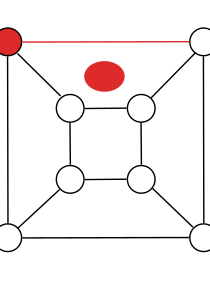

swap (v/e/f/q=quit): q


In [8]:
# Interactively allow the user to traverse the graph with mirror
# operations.

b.reload()
b.default_start()
b.show()

cmd_map = {
    'v': b.vertex_swap,
    'e': b.edge_swap,
    'f': b.face_swap,
}

while True:
    cmd_string = input('swap (v/e/f/q=quit): ')
    if 'q' in cmd_string.lower():
        break
    cmds = [
        cmd_map.get(s, lambda: print('unknown command; doing nothing'))
        for s in cmd_string.lower()
    ]
    with showing(b):
        for cmd in cmds:
            cmd()

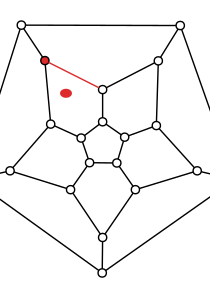

swap (v/e/f/q=quit): q


In [9]:
# Interactively allow the user to traverse the graph with mirror
# operations.

c.reload()
c.default_start()
c.show()

cmd_map = {
    'v': c.vertex_swap,
    'e': c.edge_swap,
    'f': c.face_swap,
}

while True:
    cmd_string = input('swap (v/e/f/q=quit): ')
    if 'q' in cmd_string.lower():
        break
    cmds = [
        cmd_map.get(s, lambda: print('unknown command; doing nothing'))
        for s in cmd_string.lower()
    ]
    with showing(c):
        for cmd in cmds:
            cmd()